## 0.0 Entender o problema

-- Objetivo do problema:
    -- 1.0 Previsão do primeiro destino que um novo usuário irá escolher.
    
    --Porque?
      --Qual tipo de modelo de negócio do Airbnb?
        --Marketplace (Conectar pessoas que oferecem acomodação, com as pessoas que estão procurando acomodação).
        
        --Oferta (pessoas oferecendo acomodação)
            --Tamanho do Portfólio.
            -- diversidade/Densidade de Portfólio.
            --Preço médio
        
        --Demanda (pessoa procurando acomodação)
             --Número de Usuários 
             --LTV (LifeTime Value)
             --CAC (Client Aquisition Cost)
        
        Gross Revenue = (Fee * Numero de clientes) - CAC
        
        --Demanda (pessoas procurando acomodação)
        
        
--Proposta da solução:

    --- Modelo de previsão do primeiro destino de um novo usuário.
    
    --- 1.0 Predições e salvar em uma tabela de bando de dados.
    
    ---2.0 Criar uma API
        --- Input: usuario  e suas caracteristicas
        --- Output: usuario e suas caracteristicas com a ** predição do destino**.

        
        

# 0.0 <font color ='red'>Ciclo01: End to End </font>

# 0.0 Imports

In [1]:
!pip install scikit-plot

In [10]:
import math
from scipy.stats import chi2_contingency
import scipy.stats as ss
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

import warnings

warnings.filterwarnings( 'ignore' )

import sklearn.model_selection
from sklearn import model_selection as ms
from sklearn import preprocessing   as pp
from sklearn import metrics         as m
from scikitplot import metrics      as mt
from IPython.core.display  import HTML
from IPython.core.display  import Image
#from tabulate              import tabulate

from imblearn import under_sampling as us
from imblearn import over_sampling  as oversamp
from imblearn import combine        as c

#from pandas_profiling import ProfileReport

from keras import models as ml
from keras import layers as l


# 0.1 Helper functions

In [11]:
def cramer_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher. 
        """     
    
    cm = pd.crosstab(x, y).values  #.as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcoor = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n)/ (min(kcorr-1,  rcoor-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

    
jupyter_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading Data

In [12]:
# datasets source: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data?select=sessions.csv.zip


df_raw = pd.read_csv('dataset/training_users_2.csv', low_memory=True)
df_raw.shape

df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0 Data Description

In [13]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [14]:
print( 'Number of rows: {}'.format(df1.shape[0] ) )
print( 'Number of columns: {}'.format(df1.shape[1] ) )

Number of rows: 213451
Number of columns: 16


In [15]:
print( 'Number of rows: {}'.format(df_sessions.shape[0] ) )
print( 'Number of columns: {}'.format(df_sessions.shape[1] ) )

Number of rows: 10567737
Number of columns: 6


## 1.2 Data type

In [16]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [17]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 NA Check

In [18]:
 df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [19]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [20]:
#remove missing value complety
#df1 = df1.dropna()

#========================USER===========================================

# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' )
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )


# age
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age =  round(df1['age'].mean(),2)
df1['age'] = df1['age'].fillna( avg_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

df1['first_affiliate_tracked'].value_counts()

#========================Sessions=========================================
#user_id  - 3%
df_sessions= df_sessions[~df_sessions['user_id'].isna()]

#action - 7%
df_sessions= df_sessions[~df_sessions['action'].isna()]

#action_type - 10$
df_sessions= df_sessions[~df_sessions['action_type'].isna()]

#action_detail- 10%
df_sessions= df_sessions[~df_sessions['action_detail'].isna()]

#device_type - 0%
df_sessions= df_sessions[~df_sessions['device_type'].isna()]

#secs_elapsed - 0%
df_sessions= df_sessions[~df_sessions['secs_elapsed'].isna()]



In [21]:
df_sessions.isna().sum() / len(df_sessions)

user_id          0.0
action           0.0
action_type      0.0
action_detail    0.0
device_type      0.0
secs_elapsed     0.0
dtype: float64

In [22]:
df1.isna().sum() / len(df1)

id                         0.0
date_account_created       0.0
timestamp_first_active     0.0
date_first_booking         0.0
gender                     0.0
age                        0.0
signup_method              0.0
signup_flow                0.0
language                   0.0
affiliate_channel          0.0
affiliate_provider         0.0
first_affiliate_tracked    0.0
signup_app                 0.0
first_device_type          0.0
first_browser              0.0
country_destination        0.0
dtype: float64

## 1.4 Change Data Type

In [23]:
# date_account_created    
df1["date_account_created"] = pd.to_datetime( df1["date_account_created"] )

# timestamp_first_active   
df1["timestamp_first_active"] = pd.to_datetime( df1["timestamp_first_active"], format='%Y%m%d%H%M%S' )

# date_first_booking       
df1["date_first_booking"] = pd.to_datetime( df1["date_first_booking"] )

# age       
df1["age"] = df1["age"].astype( int )

In [24]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.5 Check Balanced Data

In [25]:
df1["country_destination"].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6 Descriptive Analysis

## 1.6 General

In [26]:
# Users
num_attributes = df1.select_dtypes( include=['int32','int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int32', 'int64', 'float64','datetime64[ns]'])
time_attributes = df1.select_dtypes( include=['datetime64[ns]'])

#Sessions
num_attributes_sessions = df_sessions.select_dtypes( include=['int32','int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes( include=['datetime64[ns]'])

## 1.6.1 Numeral - Users

In [27]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenar 
ct = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes','min','max', 'range','mean','median','std','skew','kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


## 1.6.2 Numeral - Sessions

In [28]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

# concatenar 
ct = pd.concat([d2, d3, d4,ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes','min','max', 'range','mean','median','std','skew','kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


## 1.6.2 Categorical - Users

In [29]:
cat_attributes.drop('id', axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


## 1.6.3 Categorical - Sessions

In [30]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


## 1.6.2 Categorical - Sessions

In [31]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

coor_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list =  []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat=cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        # append a list
        corr_list.append(corr)
    # append a correlation list for each atributes   
    coor_dict[ref] = corr_list

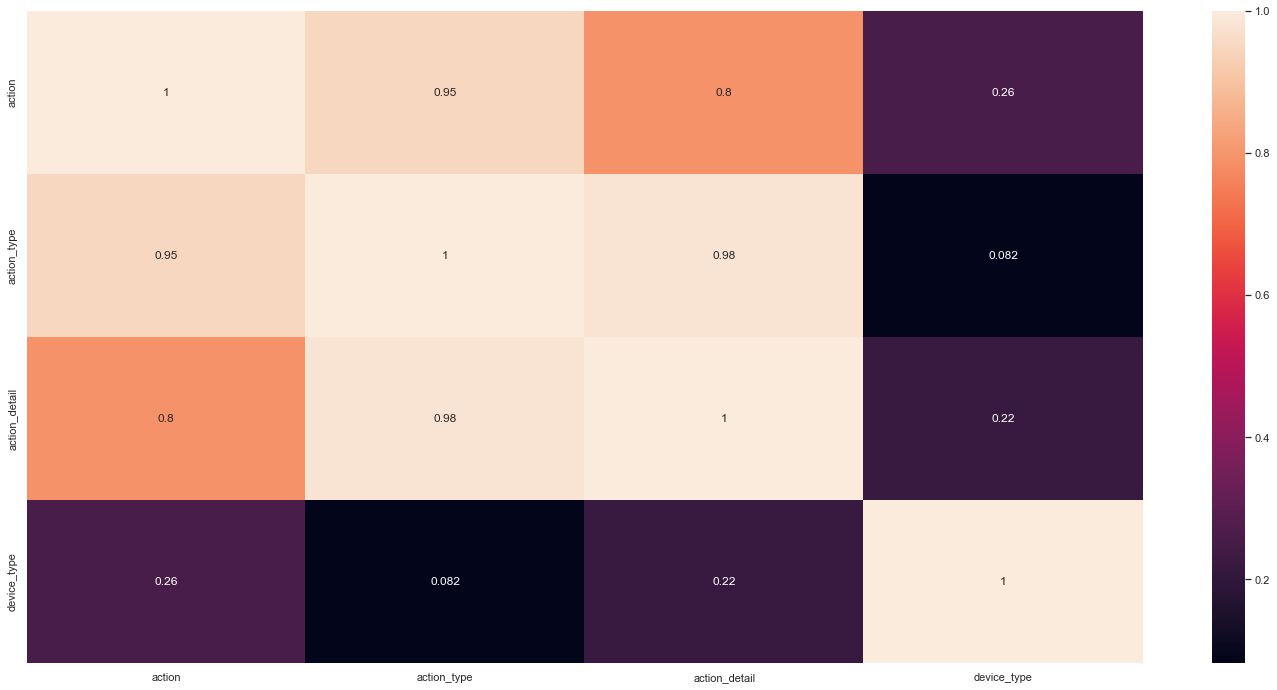

In [32]:
d = pd.DataFrame(coor_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 2.0 Feature Engineering

In [33]:
df2 = df1.copy()
df_sessions2 = df_sessions.copy()

In [34]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int32
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1 Create New Features

In [35]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime( df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ) )
df2['days_from_frist_active_until_booking'] = ( df2['date_first_booking'] - df2['first_active'] ).apply( lambda x: x.days )

# days from first active upt to account created
df2['days_from_first_active_until_account_created'] = ( df2['date_account_created'] - df2['first_active'] ).apply( lambda x: x.days )

# days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = ( df2['date_first_booking'] - df2['date_account_created'] ).apply( lambda x: x.days )

# ================== First Active ==================
# year first active
df2['year_first_active'] = df2['first_active'].dt.year

# month first active
df2['month_fist_active'] = df2['first_active'].dt.month

# day first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

# ================== First Booking ==================
# year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

# ================== First Account Created =================
# year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

# month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


# 3.0 Data filtering

In [36]:
df3 = df2.copy()
df_sessions3 = df_sessions2.copy()

## 3.1 Filtering Rows

In [37]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

# secs_elapsed - there is no possible 0 secs elapsed on website
#df3 = df3[df3['secs_elapsed'] > 0]

## 3.2 Columns Selection

In [38]:
# delete original datetime
cols = ['date_account_created','timestamp_first_active','date_first_booking','first_active']
df3 = df3.drop(cols, axis=1 )

# 4.0 Balanced Dataset

In [39]:
df4 = df3.copy()

In [40]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numeral
col_num = df4.select_dtypes(include=['int64','int32', 'float']).columns.tolist()

# Categorial
col_cat = df4.select_dtypes(exclude=['int64','int32', 'float']).drop(['id','country_destination'],axis=1).columns.tolist()

# Encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index=df4.index)

# Join numeral and  categorical 
df42 = pd.concat([df4[col_num],df4_dummy], axis=1)

##  4.1 Random Undersampling

In [41]:
# define sampler
undersampling = us.RandomUnderSampler(sampling_strategy = 'auto', random_state=32)

# apply sampler 
X_under, y_under = undersampling.fit_resample(df42, df4['country_destination'])

In [42]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [43]:
y_under.value_counts()

AU       157
CA       157
DE       157
ES       157
FR       157
GB       157
IT       157
NDF      157
NL       157
PT       157
US       157
other    157
Name: country_destination, dtype: int64

 ## 4.2 Random Oversampling

In [44]:
# define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy = 'all', random_state=32)

# apply sampler 
X_over, y_over = oversampling.fit_resample(df42, df4['country_destination'])

In [45]:
y_over.value_counts()

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

In [46]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

 ## 4.3 SMOTE + TOMELINK

In [47]:
#df4['country_destination'].value_counts().to_dict()

ratio_balanced =  {'NDF': 54852,
                   'US':  48057,
                   'other': 6*7511,
                   'FR': 12*3669,
                   'IT': 20*2014,
                   'GB': 30*1758,
                   'ES': 30*1685,
                   'CA': 40*1064,
                   'DE': 45*841,
                   'NL': 80*595,
                   'AU': 85*433,
                   'PT': 300*157}



In [48]:
# define sampler
smt = c.SMOTETomek( sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1 )

# apply sampler
X_smt, y_smt = smt.fit_resample( df42, df4['country_destination'] )


MemoryError: Unable to allocate 430. MiB for an array with shape (7511, 7511) and data type float64

In [ ]:
# numerical data
df43 = X_smt[col_num]

# categorical data
df44 = X_smt.drop(col_num, axis=1)
df45 = pd.DataFrame(ohe.inverse_transform( df44 ), columns=col_cat, index=df44.index)

# join numerical categorical
df46 = pd.concat( [df43, df45], axis=1 )
df46['country_destination'] = y_smt

# 5.0 Data Preparation

In [ ]:
df5 = df4.copy()

In [ ]:
# dummy variable
df5_dummy = pd.get_dummies( df5.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df5 = pd.concat( [df5[['id', 'country_destination']], df5_dummy], axis=1 )

In [ ]:
df5.shape

# 6.0 Feature Selection

In [ ]:
cols_drop = ["date_account_created", "timestamp_first_active","date_first_booking", 'first_active'] # original dates
df6 = df5.drop(cols_drop, axis=1)

In [ ]:
X = df6.drop('country_destination', axis=1)
y = df6['country_destination'].copy()

In [ ]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.2, random_state=32 )

# 7.0 Machine Learning - Neural Network - MLP

In [ ]:
x_train = X_train.drop("id", axis=1)
x_test = X_test.drop("id", axis=1)

## 7.1. Baseline Model 

In [ ]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
# adding the weights according to column distribution "country_destination"
country_destination_weights= df1['country_destination'].value_counts(normalize=True).sort_index().tolist()
# random model

yhat_random = random.choices(population=country_destination_list,
                             weights=country_destination_weights,              
                             k=k_num)

## 7.1.1 Baseline Model Performance

In [ ]:
# Acurracy
acc_random = m.accuracy_score(y_test, yhat_random )
print("Accuracy: {}".format(acc_random))

# Balanced accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print("Balanced Accuracy: {}".format(balanced_acc_random))

#Kappa Metrics
Kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print("Kappa Score: {}".format(balanced_acc_random))

#Classification report
print(m.classification_report(y_test, yhat_random))


# Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12) )

# 7.2 Neural Network - MLP

In [ ]:
# One Hot Encoder
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape(-1, 1) ).toarray()

In [ ]:
y_train_nn

In [ ]:
x_train.shape

In [ ]:
# model definition
model = ml.Sequential()
model.add(l.Dense( 256,input_dim=x_train.shape[1], activation='relu') )
model.add(l.Dense(12, activation="softmax") )

# model compile
model.compile( loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )

model.fit( x_train, y_train_nn, epochs=100, verbose=0)

In [ ]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

## 7.2.2 NN Performance

In [ ]:
# Acurracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn )
print("Accuracy: {}".format(acc_nn))

# Balanced accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print("Balanced Accuracy: {}".format(balanced_acc_nn))

#Kappa Metrics
Kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print("Kappa Score: {}".format(Kappa_nn))

#Classification report
print(m.classification_report(y_test_nn, yhat_nn))


# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12) )
#

## 7.2.3 NN Performance - Cross Validation

In [ ]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_nn_list =[]
Kappa_nn_list = []
i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print("fold number: {}/{}".format(i, num_folds))
          
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding --> categorical to numeral
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1, 1)).toarray()

    # model defition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=x_train.shape[1], activation="relu"))
    model.add(l.Dense(12, activation="softmax"))

    # compile model
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn) # numeral to categorical


    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    Yhat_nn = yhat_nn.reshape(-1, 1)[0]

    # metrics

    # Balanced accuracy
    balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_nn_list.append(balanced_acc_nn)
    #print("Balanced Accuracy: {}".format(balanced_acc_nn))

    #Kappa Metrics
    Kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    Kappa_nn_list.append(Kappa_nn)
    #print("Kappa Score: {}".format(Kappa_nn))

    i += 1

In [ ]:
print("avg Balanced Accuracy:  {} +/- {}".format(round(np.mean(balanced_acc_nn_list), 4),
                                                np.round(np.std(balanced_acc_nn_list), 4)))


In [ ]:
print("avg Kappa score: {} +/- {}".format(np.round(np.mean(Kappa_nn_list), 4),
                                          np.round(np.std(Kappa_nn_list), 4)))